In [1]:
import numpy as np
import torch as ch
import matplotlib.pyplot as plt
from tqdm import tqdm
from aicsimageio import AICSImage
import ipywidgets as widgets

from confocalQuant.segmentation import (
    show_im,
    load_2D,
    threshold_im,
    update_image,
    load_3D,
    apply_thresh_all_Z,
    do_inference,
    get_anisotropy,
    sigmoid,
    toggle_segmentation,
    extract_channels,
    show_maxproj_with_outlines,
    hide_masks,
    run_med_filter,
    gamma_correct_image,
    int_to_float,
    float_to_int, 
    display_image, 
    on_filter_change, 
    toggle_filters
    
)
from confocalQuant.quantification import get_im_stats
from cellpose import models

/home/gridsan/djuna/.local/lib/python3.8/site-packages/pydantic/_migration.py:281: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


### Prep the image

In [28]:
# specify channels to load
channels = [0,1,2] # channel order SREBPorTOMM20/NeuN/DAPI

# specify path
path = './data/10252023_Tomm20_matchedcohort/10290265con_4.czi'

# load image
img = AICSImage(path)
out = load_3D(img, channels)

# convert to float
out_float = int_to_float(out)

In [35]:
out_float[20][:,:,0]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00392157, 0.        , 0.        , ..., 0.0745098 , 0.02745098,
        0.0627451 ],
       [0.        , 0.        , 0.        , ..., 0.0745098 , 0.05882353,
        0.03137255],
       [0.        , 0.        , 0.        , ..., 0.06666667, 0.05098039,
        0.0627451 ]])

In [14]:
import numba as nb
from scipy import signal

@nb.njit()
def run_med_filter(out_float, kernel_size=3):
    out_med = out_float.copy()

    for i in (range(out_med.shape[0])):
        for j in range(out_med.shape[-1]):
            out_med[i,:,:,j] = median_filter_2d(out_float[i,:,:,j], kernel_size=kernel_size)
    return out_med

In [13]:
from numba import njit
import numpy as np

@njit
def median_filter_2d(image, kernel_size):
    result = np.empty_like(image)
    pad = kernel_size // 2

    for i in range(pad, image.shape[0] - pad):
        for j in range(pad, image.shape[1] - pad):
            result[i, j] = np.median(image[i - pad : i + pad + 1, j - pad : j + pad + 1])

    return result

In [26]:
temp = run_med_filter(out_float, 3)
temp.shap

KeyboardInterrupt: 

In [29]:
out_float.shape

(37, 1024, 1024, 3)

In [3]:
toggle, median, background_dict, gamma_dict, upper_dict, lower_dict = toggle_filters(out_float)
toggle

In [5]:
# run med filter to remove noise
out_med = run_med_filter(out_float, kernel_size = 3)

# perform gamma correction for visualization
out_med_gamma = gamma_correct_image(out_med, gamma_dict, lower_dict, upper_dict)


100%|██████████| 37/37 [00:10<00:00,  3.37it/s]


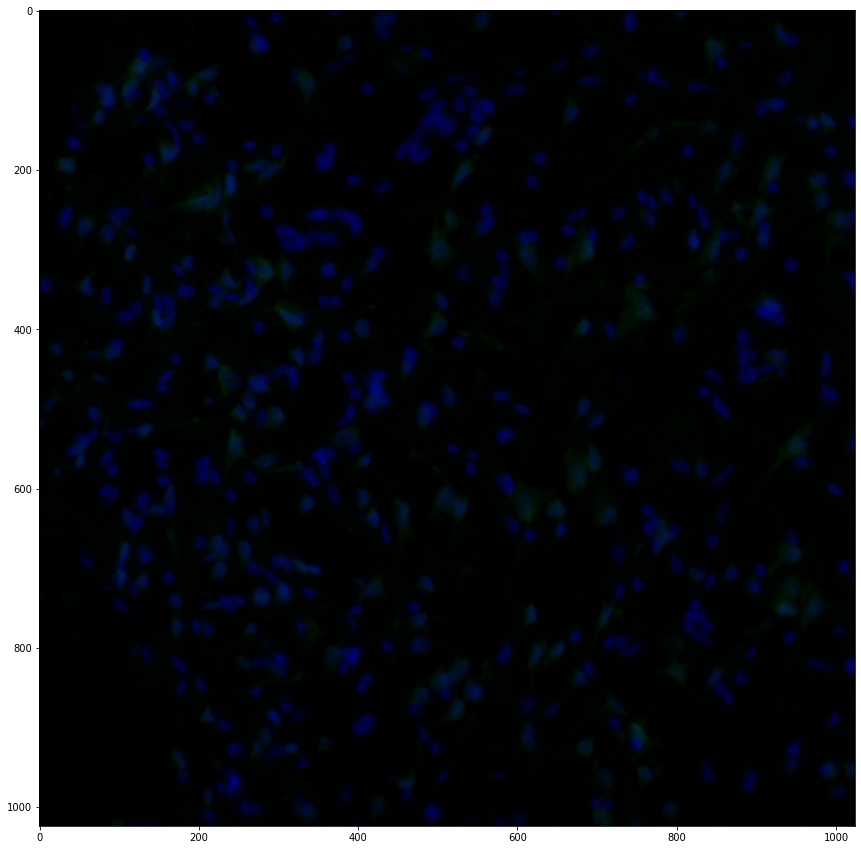

In [20]:
# show projection
out_med_gamma_sele = extract_channels([1,2], out_med_gamma)
out_med_gamma_mean_proj = (np.mean(out_med_gamma_sele, axis=(0)))
plt.figure(figsize = (15,15))
plt.imshow(out_med_gamma_mean_proj)

### Do inference

In [134]:
# get anisotropy
anisotropy = get_anisotropy(img)
print('Anisotropy: ' + str(anisotropy))

# load model
model = models.Cellpose(gpu = True, model_type='cyto2')

# run inference
masks, flows = do_inference(out_med, do_3D=True, model=model, anisotropy=anisotropy, diameter=20, channels=[2,3], channel_axis=3, z_axis=0, min_size=1100, normalize = False)

2.4088670663621183


### Toggle through segmentation

In [206]:
# choose which channel(s) to show
out_med_gamma_sele = extract_channels([1],[0,1,2], out_med_gamma)

# toggle through segmentation
toggle_segmentation(out_med_gamma_sele, masks)

/state/partition1/slurm_tmp/24324465.0.0/ipykernel_1404157/1545501408.py:8: RuntimeWarning: invalid value encountered in divide
  image_float = np.clip((image_float-lower)/(upper-lower), a_min = 0, a_max = 1)


### Show 2D projections

100%|██████████| 37/37 [00:01<00:00, 19.53it/s]


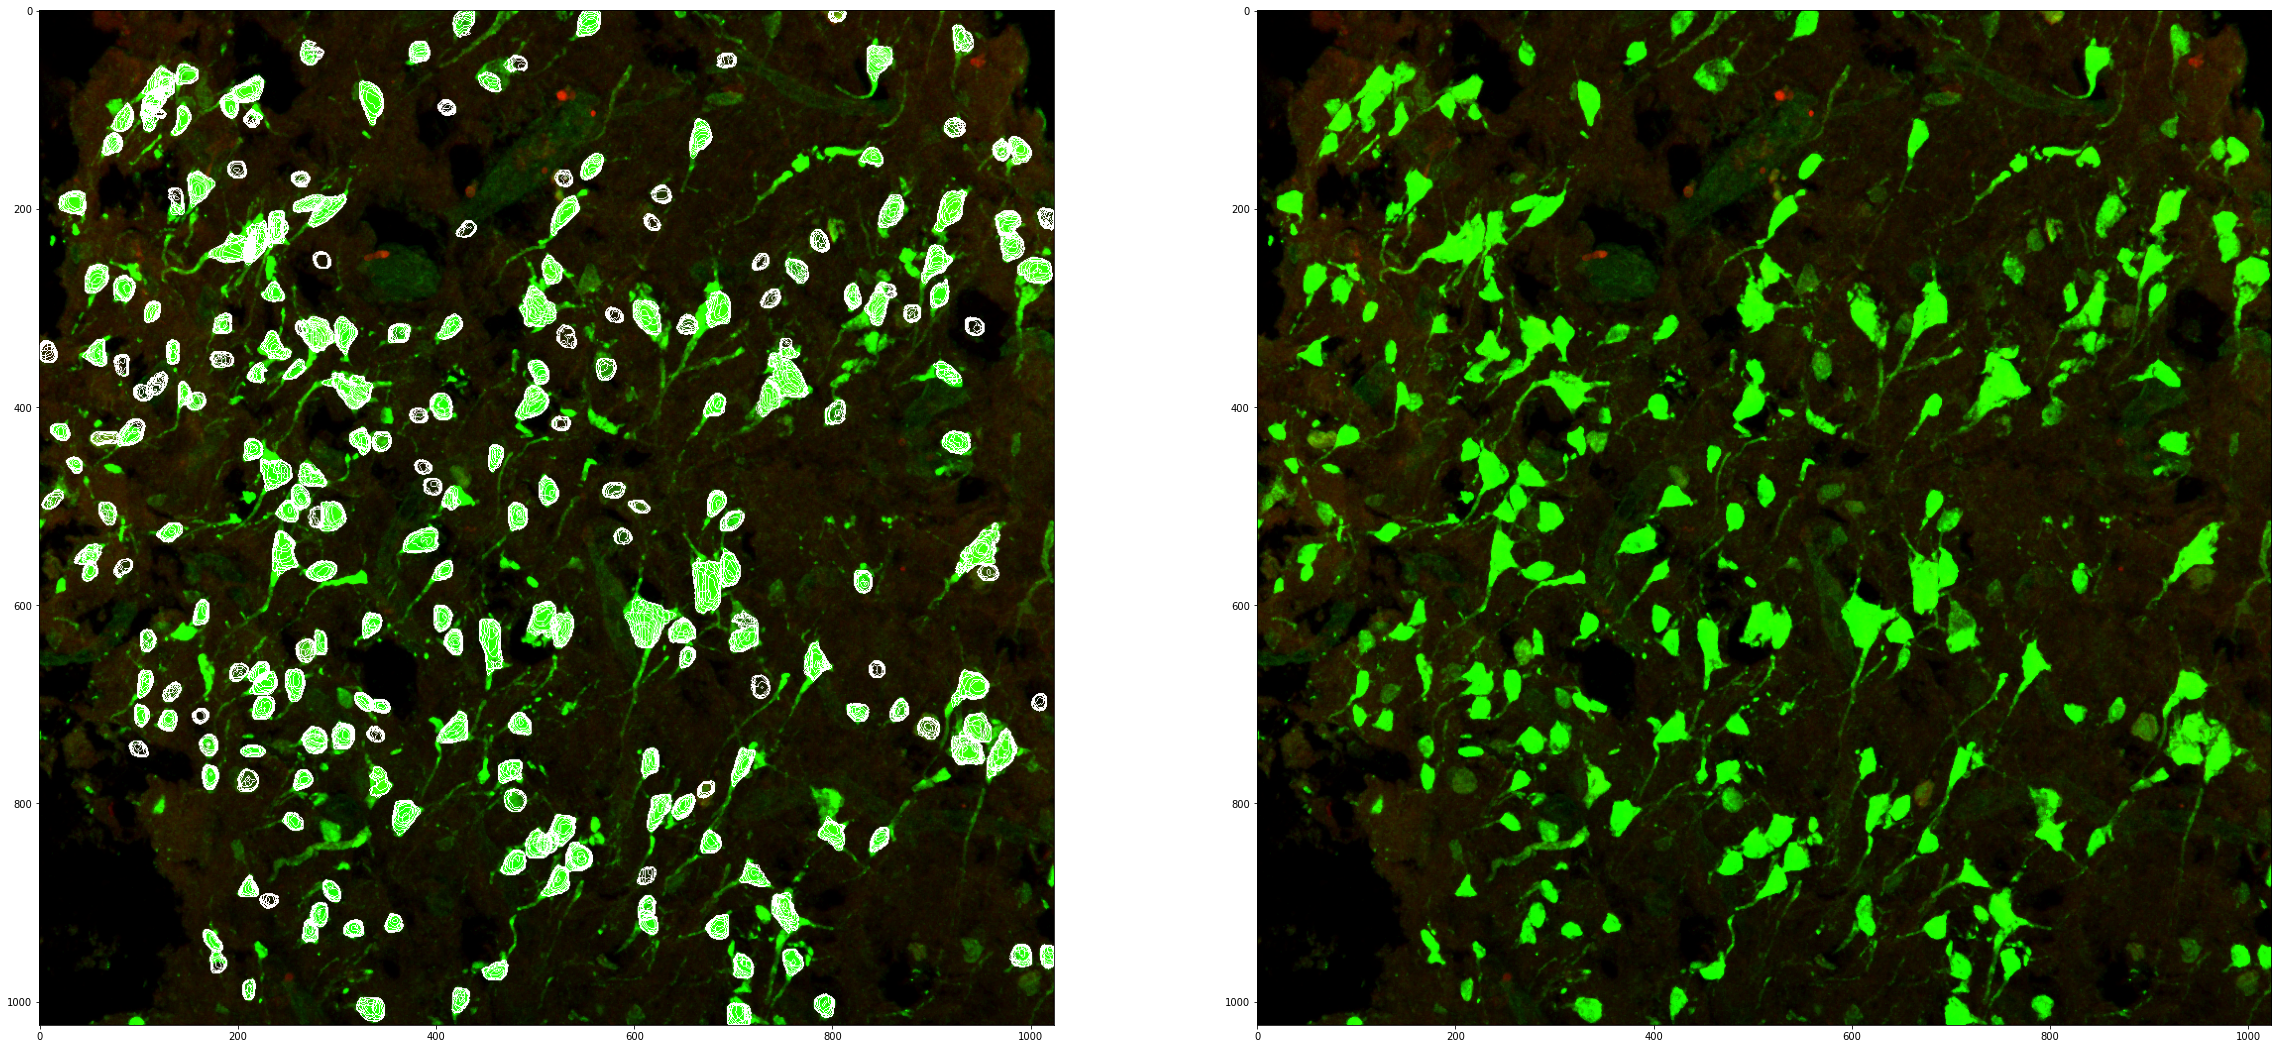

In [177]:
# plot mean intensity projections with and without segmentation
fig, axs = plt.subplots(1, 2, figsize=(40, 40)) 

# remove masks for the second plot
masks_temp = masks.copy()
masks_temp[masks_temp>0]=0

axs[0].imshow(show_maxproj_with_outlines(out_med_gamma_sele, masks)) # make this a mean projection
axs[1].imshow(show_maxproj_with_outlines(out_med_gamma_sele, masks_temp))

In [ ]:
# subtract background from green channel (x percent) before running model to remove the halucinations due to background
# Do that same subtraction for the channel of interest that we care about (ie. to remove background)
# Don't show max projection, but mean projection

### Get image stats

In [74]:
# get the image stats
Y = get_im_stats(masks, mat2, probs) # this should be on out_med with background subtraction

100%|██████████| 153/153 [01:23<00:00,  1.83it/s]


In [80]:
# maybe further filter segmentation
C2 = np.percentile(Y[:,2], 10, axis=(0))
C1 = np.percentile(Y[:,1], 10, axis=(0))
V = np.percentile(Y[:,3], 15, axis=(0))

dictionary2 = dict(zip(range(4), [0, C1, C2, V]))

masks_copy = masks.copy()
hide_masks(Y, masks_copy, dictionary)

toggle_segmentation(mat2, masks_copy)